In [1]:
import pandas as pd
%matplotlib inline

# import s3 support lib
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

bucket = "trans-records"
file_name = "transactions.csv"

# Load transactions data and prep features

In [2]:
df = get_dataframe_from_file(bucket, file_name)

In [3]:
df.shape

(7624727, 35)

In [4]:
df.columns

Index(['amount', 'amount_std', 'creatingTransactionFor', 'date', 'day',
       'donations_amt', 'donations_count', 'email', 'events_amt',
       'events_count', 'events_tickets', 'form', 'form_amount_mean_diff',
       'form_day_mean_diff', 'form_hour_mean_diff', 'hour', 'id', 'is_fraud',
       'is_recurring', 'month', 'org', 'purchases_amt', 'purchases_count',
       'purchases_quantity', 'recurring', 'recurring_creatingTransaction',
       'registrations_amt', 'registrations_count', 'source', 'state', 'status',
       'transDonationEntity', 'transDonationEntityType', 'year', 'zip'],
      dtype='object')

In [5]:
# narrow the dataset to just the features we need
df = df[['id', 'email', 'amount', 'is_recurring', 'recurring', 'status', 'source', 'year']]

In [6]:
df['is_recurring'] = df['is_recurring'].astype('bool')

# Calculate system wide retention

In [7]:
df_acc = df[(df['status']=='A')&(df['recurring']==0)]

In [8]:
df_donor_agg = df_acc.groupby(['email', 'year']).agg({'amount': 'sum', 'id': 'count'}).reset_index()
df_donor_agg['count'] = df_donor_agg['id']
df_donor_agg['sum'] = df_donor_agg['amount']
df_donor_agg.drop(['id', 'amount'], axis=1, inplace=True)
df_donor_agg['year'] = df_donor_agg['year'].astype('int')

In [9]:
df_donor_agg.head()

,email,year,count,sum
0,000005c13615de85ea6671d12dc3b6f28a002f75,2015,1,0.0
1,00000c446df8106addf69292ac1971cda5810417,2014,2,80.0
2,00000f5e6b5b33abbef8fd1617d2fe024d719fee,2017,1,50.0
3,00001067aca2292434e4576532386f6a79c9f64d,2012,3,150.0
4,000019bf170ab66eaf414a7bbf9477c8888e2d69,2015,1,50.0


## Unique donors and average donations per donor over the years

In [10]:
df_donor_year_agg = df_donor_agg.groupby('year').agg({'email': 'count', 'count': 'mean', 'sum': 'mean'}).reset_index()

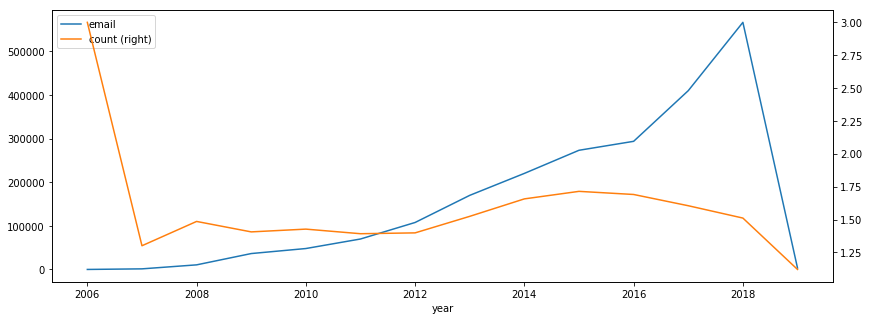

In [11]:
df_donor_year_agg[['year', 'email', 'count']].plot(x='year', secondary_y='count', figsize=(14,5))

## Calculating annual retention

In [12]:
annual_data = []

for year in df_donor_agg['year'].unique():
    _this_year = df_donor_agg[df_donor_agg['year']==year]
    _last_year = df_donor_agg[df_donor_agg['year']==(year-1)]
    
    this_years_donors = _this_year['email'].unique()
    overlap_donors = None
    if len(_last_year):
        overlap_donors = len(_last_year[_last_year['email'].isin(this_years_donors)])
    
    annual_data.append({
        'year': year,
        'unique_donors': len(this_years_donors),
        'donors_from_last_year': overlap_donors
    })

In [13]:
annual_retention = pd.DataFrame(annual_data).dropna()
annual_retention['unique_donors'] = annual_retention['unique_donors'].astype('int')
annual_retention['donors_from_last_year'] = annual_retention['donors_from_last_year'].astype('int')
annual_retention['annual_retention'] = (annual_retention['donors_from_last_year'] / annual_retention['unique_donors']) * 100.

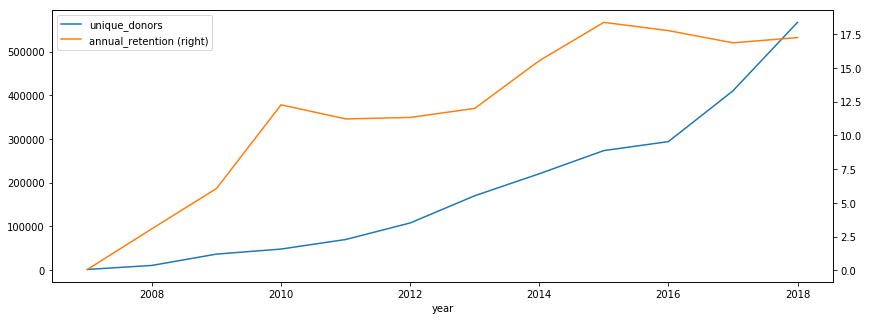

In [14]:
annual_retention[annual_retention['year']!=2019].sort_values('year', ascending=True)[['year', 'unique_donors', 'annual_retention']].plot(x='year', secondary_y='annual_retention', figsize=(14,5))

In [18]:
annual_retention.sort_values('year', ascending=True)

,donors_from_last_year,unique_donors,year,annual_retention
12,1,1355,2007,0.073801
10,325,10522,2008,3.088766
7,2212,36446,2009,6.069253
9,5886,47973,2010,12.269402
8,7838,69832,2011,11.224081
3,12207,107722,2012,11.331947
5,20401,169942,2013,12.004684
1,34226,220291,2014,15.536722
0,50225,273321,2015,18.375829
6,52196,293843,2016,17.763227


In [17]:
save_dataframe_to_file("qgiv-stats-data", "annual_retention.csv", annual_retention.sort_values('year', ascending=True))

uploading to S3
Done
